In [41]:
from mario_scenes.load_data import load_scenes_info
from mario_replays.load_data import load_replay_data
import os
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load data

scenes_mastersheet = load_scenes_info(format='df')
# Drop Entry Point and Exit Point columns
scenes_mastersheet = scenes_mastersheet.drop(columns=['Entry point', 'Exit point', 'Valley', 'Checkpoint'])


df_list = []
sourcedata = '../../mario_learning.behavior/sourcedata/'
output_csv = '../outputdata/clips_metadata.csv'
if not os.path.exists(output_csv):    
    for clips_dir in os.listdir(sourcedata):
        if 'replays' not in clips_dir and '.' not in clips_dir: 
            print(clips_dir)
            sidecars_df = load_replay_data(os.path.join(sourcedata, clips_dir), type='metadata')
            
            if "StateClipCode" in sidecars_df.columns:
                sidecars_df = sidecars_df.rename(columns={"StateClipCode": "ClipCode"})
            df_list.append(sidecars_df)

    full_df = pd.concat(df_list)
    full_df.loc[full_df["Model"].isnull(), "Model"] = "human"
    full_df.to_csv(output_csv, index=False)
else:
    full_df = pd.read_csv(output_csv)


# Split early and late part of the phases.
mask = full_df["Model"].eq("human")
med = (
    full_df.loc[mask]
           .groupby(["Subject", "Phase", "LevelFullName"])["ClipCode"]
           .transform("median")
)
full_df.loc[mask, "Phase_stage"] = np.where(
    full_df.loc[mask, "ClipCode"] < med,
    "Early",
    "Late"
)
clips_metadata = full_df
full_df

/tmp/ipykernel_108580/1043651080.py:24: DtypeWarning: Columns (1,6,26,27,31) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv(output_csv)


,Model,StateFileName,LevelFullName,Scene,ClipCode,TotalFrames,Bk2Filepath,GameName,Subject,World,...,Run,StartFrame,EndFrame,Bk2File,SceneFullName,IndexInRun,IndexGlobal,IndexLevel,Phase,Phase_stage
0,ppo_mario_ep-20,scene_clips/sub-01/ses-001/beh/savestates/sub-...,w1l2,0,102000000116,188,ppo_mario_ep-20/sub-01/ses-001/beh/bk2/sub-01_...,SuperMarioBros-Nes,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ppo_mario_ep-20,scene_clips/sub-01/ses-001/beh/savestates/sub-...,w1l3,1,103050000227,72,ppo_mario_ep-20/sub-01/ses-001/beh/bk2/sub-01_...,SuperMarioBros-Nes,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ppo_mario_ep-20,scene_clips/sub-01/ses-001/beh/savestates/sub-...,w2l1,10,104060001144,143,ppo_mario_ep-20/sub-01/ses-001/beh/bk2/sub-01_...,SuperMarioBros-Nes,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ppo_mario_ep-20,scene_clips/sub-01/ses-001/beh/savestates/sub-...,w1l1,0,101000000122,127,ppo_mario_ep-20/sub-01/ses-001/beh/bk2/sub-01_...,SuperMarioBros-Nes,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ppo_mario_ep-20,scene_clips/sub-01/ses-001/beh/savestates/sub-...,w1l1,0,101010000122,127,ppo_mario_ep-20/sub-01/ses-001/beh/bk2/sub-01_...,SuperMarioBros-Nes,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336841,human,NaN,w6l2,12,2504030006642,12456,NaN,SuperMarioBros-Nes,6,6,...,4.0,6642.0,6825.0,sub-06_ses-025_run-04_level-w6l2_scene-12_clip...,w6l2s12,3.0,604.0,24.0,practice,Late
336842,human,NaN,w6l2,12,2504030010047,12456,NaN,SuperMarioBros-Nes,6,6,...,4.0,10047.0,10276.0,sub-06_ses-025_run-04_level-w6l2_scene-12_clip...,w6l2s12,3.0,604.0,24.0,practice,Late
336843,human,NaN,w6l2,13,2504030006825,12456,NaN,SuperMarioBros-Nes,6,6,...,4.0,6825.0,7320.0,sub-06_ses-025_run-04_level-w6l2_scene-13_clip...,w6l2s13,3.0,604.0,24.0,practice,Late
336844,human,NaN,w6l2,13,2504030010276,12456,NaN,SuperMarioBros-Nes,6,6,...,4.0,10276.0,10742.0,sub-06_ses-025_run-04_level-w6l2_scene-13_clip...,w6l2s13,3.0,604.0,24.0,practice,Late


In [63]:
def plot_cleared_by_pattern(clips_metadata, scenes_mastersheet, ax=None, sort=True, sort_by='rank', 
                             figsize=(12, 5), title="Average Cleared", palette="tab10", split_by=None,
                             clusters=None, cluster_id=20):
    """
    Plot average 'Cleared' per pattern (default) or per cluster (if clusters is provided).
    
    Parameters:
    - clips_metadata: pd.DataFrame
    - scenes_mastersheet: pd.DataFrame
    - ax: matplotlib axis
    - sort: bool, if False, disables sorting regardless of sort_by
    - sort_by: 'rank' (by avg cleared), 'name' (alphabetical), or None (original order)
    - figsize: tuple, used if ax is None
    - title: str, plot title
    - palette: color palette
    - split_by: 'Model' or 'Subject' or None
    - clusters: dict or None, if provided, use cluster-based grouping
    - cluster_id: int, which clustering to use from the dict
    """
    # Filter and prepare clips_metadata
    clips = clips_metadata.copy()
    clips = clips.dropna(subset=["World", "Level", "Scene", "Cleared"])
    clips["SceneKey"] = clips["World"].astype(int).astype(str) + "-" + \
                        clips["Level"].astype(int).astype(str) + "-" + \
                        clips["Scene"].astype(int).astype(str)
    clips["Cleared"] = pd.to_numeric(clips["Cleared"], errors='coerce')
    clips = clips.dropna(subset=["Cleared"])

    # Prepare scenes_mastersheet
    scenes = scenes_mastersheet.dropna(subset=["World", "Level", "Scene"]).copy()
    scenes["SceneKey"] = scenes["World"].astype(int).astype(str) + "-" + \
                         scenes["Level"].astype(int).astype(str) + "-" + \
                         scenes["Scene"].astype(int).astype(str)

    # Merge to get cleared per scene
    merged = pd.merge(clips, scenes[["SceneKey"]], on="SceneKey", how="inner")

    def determine_order(values, sort_by, label_name):
        if not sort:
            return values
        if sort_by == 'rank':
            return values.groupby(label_name)["Cleared"].mean().sort_values(ascending=False).index
        elif sort_by == 'name':
            return sorted(values[label_name].unique())
        else:
            return values[label_name].unique()

    if clusters is not None:
        # Cluster mode
        cluster_assignments = clusters[cluster_id]['index']
        scenes = scenes.reset_index(drop=True)
        scenes['Cluster'] = cluster_assignments

        merged = pd.merge(merged, scenes[['SceneKey', 'Cluster']], on='SceneKey', how='left')

        group_cols = ['Cluster']
        if split_by:
            group_cols.append(split_by)
        grouped = merged.groupby(group_cols)["Cleared"].mean().reset_index()

        order = determine_order(grouped, sort_by, "Cluster")

        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)

        if split_by:
            sns.barplot(data=grouped, x="Cluster", y="Cleared", hue=split_by, order=order, ax=ax, palette=palette)
            ax.legend(title=split_by, bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            sns.barplot(data=grouped, x="Cluster", y="Cleared", order=order, ax=ax, color=sns.color_palette(palette)[0])
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()

        ax.set_xlabel("Cluster")
    else:
        # Pattern mode
        pattern_columns = scenes.columns[7:-1]
        clips_with_patterns = pd.merge(clips, scenes[["SceneKey"] + list(pattern_columns)], on="SceneKey", how="inner")

        melted = clips_with_patterns.melt(
            id_vars=["SceneKey", "Cleared"] + ([split_by] if split_by else []),
            value_vars=pattern_columns,
            var_name="Pattern", value_name="HasPattern"
        )
        melted = melted[melted["HasPattern"] == 1]

        group_cols = ["Pattern"]
        if split_by:
            group_cols.append(split_by)
        grouped = melted.groupby(group_cols)["Cleared"].mean().reset_index()

        order = determine_order(grouped, sort_by, "Pattern")

        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)

        if split_by:
            sns.barplot(data=grouped, x="Pattern", y="Cleared", hue=split_by, order=order, ax=ax, palette=palette)
            ax.legend(title=split_by, bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            sns.barplot(data=grouped, x="Pattern", y="Cleared", order=order, ax=ax, color=sns.color_palette(palette)[0])
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()

        ax.set_xlabel("Pattern")

    # Final plot styling
    ax.set_ylabel("Average Cleared")
    ax.set_title(title)
    ax.set_ylim(0, 1.05)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, linestyle='--', alpha=0.6)
    ax.xaxis.grid(False)
    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()
    return ax



In [54]:
# Prepare the various filtered DFs

discovery_df = clips_metadata[clips_metadata['Phase'] == 'discovery']
practice_df = clips_metadata[clips_metadata['Phase'] == 'practice']
models_df = clips_metadata[clips_metadata['Model'] != 'human']
humans_df = clips_metadata[clips_metadata['Model'] == 'human']
phasesplit_df = clips_metadata.copy()
phasesplit_df = phasesplit_df[phasesplit_df['Model'] == 'human']
phasesplit_df.loc[phasesplit_df["Model"] == 'human', "Model"] = 'Humans ' + phasesplit_df['Phase'] + ' ' + phasesplit_df['Phase_stage']


/home/hyruuk/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/hyruuk/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/hyruuk/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/hyruuk/.local/lib/python3.10/site-packages/seabor

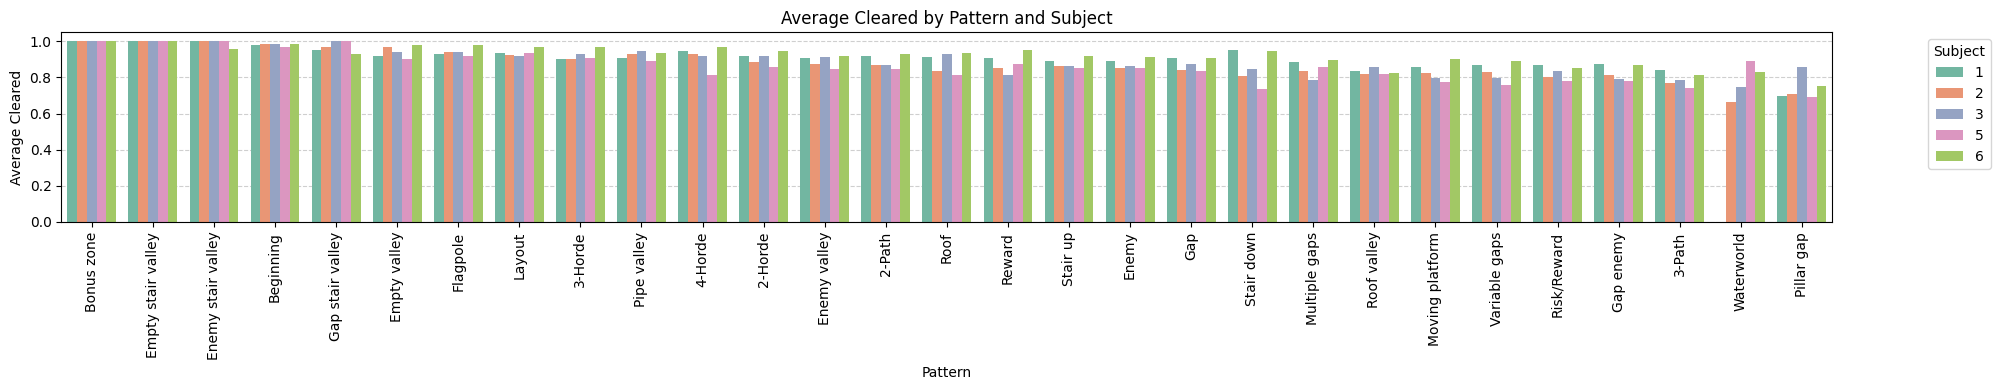

In [74]:
### Difficulty per pattern, per subject

fig, ax = plt.subplots(figsize=(20, 4))
plot_cleared_by_pattern(humans_df, scenes_mastersheet, ax=ax, split_by='Subject', palette='Set2', sort=True, sort_by='rank', title="Average Cleared by Pattern and Subject")
plt.show()


/home/hyruuk/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/hyruuk/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/hyruuk/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/hyruuk/.local/lib/python3.10/site-packages/seabor

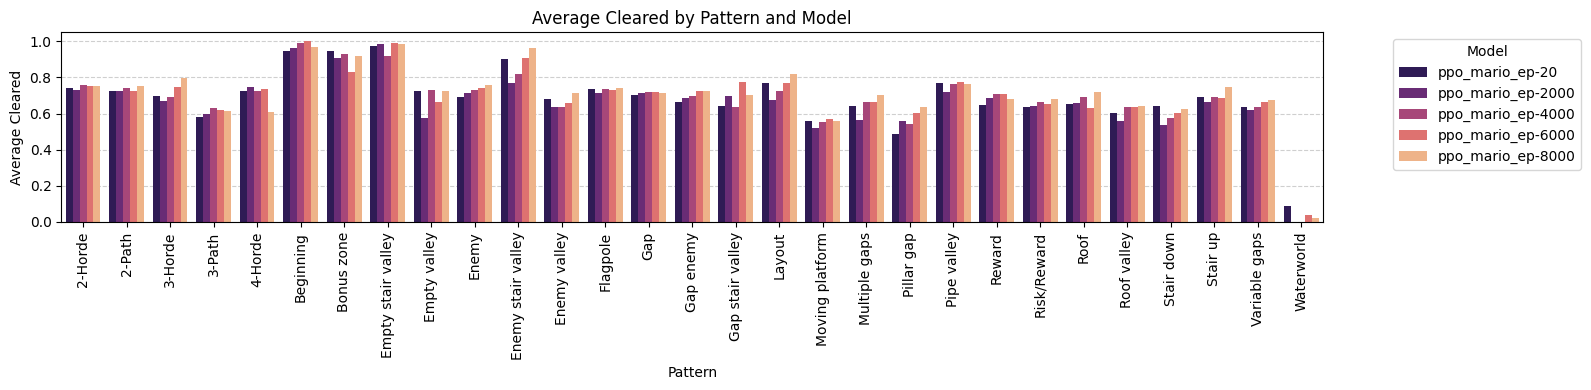

In [66]:
### Difficulty per pattern, per model vs per subject phase
fig, ax = plt.subplots(figsize=(16, 4))
plot_cleared_by_pattern(models_df, scenes_mastersheet, ax=ax, split_by='Model', palette='magma', title="Average Cleared by Pattern and Model", sort_by='name')
plt.show()

/home/hyruuk/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/hyruuk/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/hyruuk/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/hyruuk/.local/lib/python3.10/site-packages/seabor

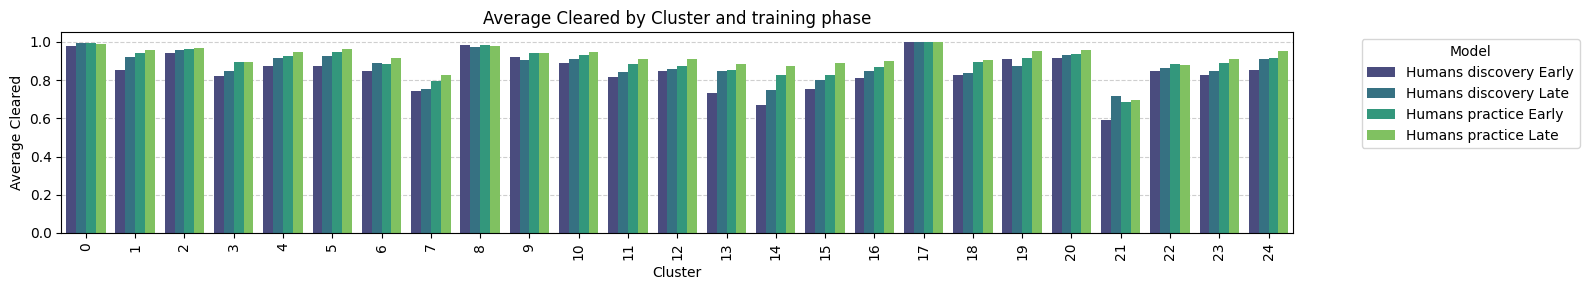

In [67]:
### Difficulty per scene cluster, per model vs per subject phase
import pickle as pkl
with open('../outputdata/clusters.pkl', 'rb') as f:
    clusters = pkl.load(f)

fig, ax = plt.subplots(figsize=(16, 3))
plot_cleared_by_pattern(phasesplit_df, scenes_mastersheet, ax=ax, split_by='Model', palette='viridis', clusters=clusters, title="Average Cleared by Cluster and training phase", cluster_id=20, sort=True, sort_by='name')
plt.show()



/home/hyruuk/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/hyruuk/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/hyruuk/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/hyruuk/.local/lib/python3.10/site-packages/seabor

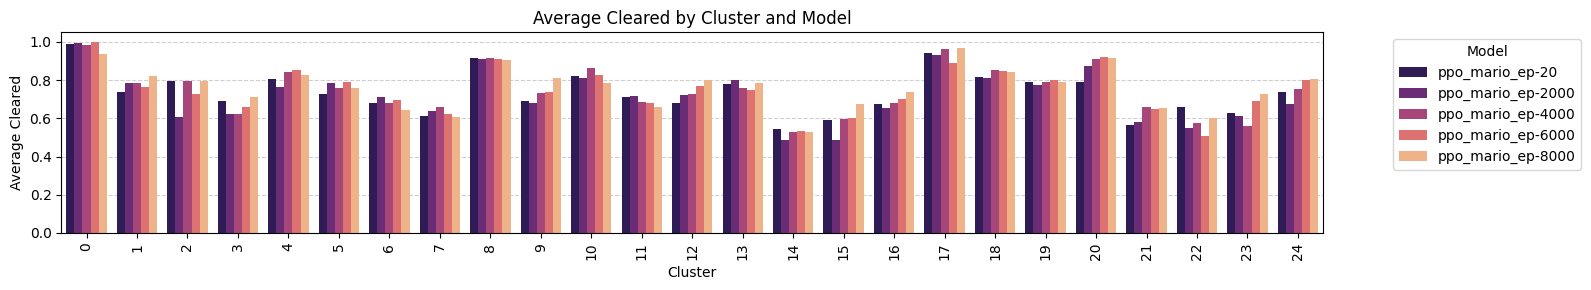

In [68]:
fig, ax = plt.subplots(figsize=(16, 3))
plot_cleared_by_pattern(models_df, scenes_mastersheet, ax=ax, split_by='Model', palette='magma', clusters=clusters, title="Average Cleared by Cluster and Model", cluster_id=20, sort=True, sort_by='name')
plt.show()
